In [1]:
import pandas as pd
import numpy as np
import os
from structlog import get_logger
import matplotlib.pyplot as plt


logger = get_logger()

# Load Dataset

In [2]:
df_train = pd.read_csv('trading_the_close_data/train.csv')
df_test = pd.read_csv('trading_the_close_data/example_test_files/test.csv')
df_test_targets = pd.read_csv('trading_the_close_data/example_test_files/revealed_targets.csv')[['stock_id', 'date_id', 'seconds_in_bucket', 'revealed_target']]

# sort the data by stock_id, date_id, seconds_in_bucket
df_train = df_train.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'])
df_test = df_test.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'])
df_test_targets = df_test_targets.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'])

# merge df_test and df_test_targets based on stock_id date_id	seconds_in_bucket
df_test = df_test.merge(df_test_targets, on=['stock_id', 'date_id', 'seconds_in_bucket'], how='inner')
# select all  columns except revealed_target
df_test, y_test = df_test[df_test.columns.difference(['revealed_target'])] , df_test['revealed_target']
df_test['target'] = y_test
df_test.drop(['currently_scored'], axis=1, inplace=True)
del df_test_targets


# sort the data by stock_id, date_id, seconds_in_bucket
df_train = df_train.sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id'])
df_test = df_test.sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id'])




In [3]:
df_train.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [4]:
days_to_filter = set()
for (date_id, seconds_in_bucket), stock_ids in df_train.groupby(['date_id', 'seconds_in_bucket'])['stock_id']:
    breakpoint()
    if len(stock_ids) != 200:
        days_to_filter.add(date_id)   

# remove days with less than 200 stock_ids
df_train = df_train[~df_train['date_id'].isin(days_to_filter)]
df_train.groupby(['date_id', 'seconds_in_bucket']).size().value_counts()


days_to_filter = set()
for (date_id, seconds_in_bucket), stock_ids in df_test.groupby(['date_id', 'seconds_in_bucket'])['stock_id']:
    breakpoint()
    if len(stock_ids) != 200:
        days_to_filter.add(date_id)   

# remove days with less than 200 stock_ids
df_test = df_test[~df_test['date_id'].isin(days_to_filter)]
df_test.groupby(['date_id', 'seconds_in_bucket']).size().value_counts()

200    165
Name: count, dtype: int64

In [5]:
len(df_train), len(df_test)

(2035000, 33000)

In [6]:
df_test.describe()
# describe df_test missing values and data types
df_test.info()



<class 'pandas.core.frame.DataFrame'>
Index: 33000 entries, 0 to 32999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ask_price                33000 non-null  float64
 1   ask_size                 33000 non-null  float64
 2   bid_price                33000 non-null  float64
 3   bid_size                 33000 non-null  float64
 4   date_id                  33000 non-null  int64  
 5   far_price                14771 non-null  float64
 6   imbalance_buy_sell_flag  33000 non-null  int64  
 7   imbalance_size           33000 non-null  float64
 8   matched_size             33000 non-null  float64
 9   near_price               15000 non-null  float64
 10  reference_price          33000 non-null  float64
 11  row_id                   33000 non-null  object 
 12  seconds_in_bucket        33000 non-null  int64  
 13  stock_id                 33000 non-null  int64  
 14  time_id                  33

# stocks         : 200
# dates          : 3
# updates per day: 55


  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:00<00:00, 1553.05it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Fit >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Coef: [ 1.40698934e-02  3.71671078e-02  1.89081128e-02 -2.27663658e-02
 -3.48099986e-02  5.35631471e-03 -1.72697033e-02 -1.20366859e-02
  1.43197223e-02  2.09418856e-02 -2.63947297e-03  1.53954344e-02
 -1.19964364e-02 -1.95028242e-02  8.82462466e-03 -1.75892697e-02
 -5.51944617e-03  4.29028375e-03  5.40409802e-04 -1.15501866e-02
  2.45833979e-03  1.33564018e-02  2.30068760e-02 -3.82237969e-04
  5.97837995e-03 -1.49262164e-03 -2.31145894e-02  3.64347609e-02
 -1.45238025e-02 -3.92808754e-02  3.12030525e-02  2.12771185e-03
  3.92207485e-02  1.35792284e-02 -3.17240060e-02 -5.32379910e-04
  3.68672144e-02  1.36717428e-02  3.09615333e-02  1.00613787e-02
 -1.34615635e-02  7.91976456e-03  2.21020290e-02  3.87770212e-02
  1.12284592e-02 -2.00031126e-02 -1.37284994e-02  1.00127583e-02
  1.35393499e-02  8.51235352e-04  2.81010358e-02 -1.20964610e-02
 -3.29466906e-02  4.39996687e-02  1.61043989e-02 -2.59144991e-02
  4

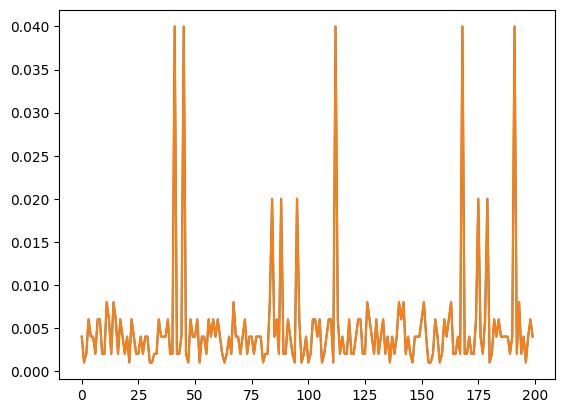

In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm
import polars as pl


def get_stock_index_coeficient(df):
    num_stocks = df["stock_id"].nunique()
    num_dates = df["date_id"].nunique()
    num_updates = df["seconds_in_bucket"].nunique()

    num_dates_map = {v:i for i, v in enumerate(sorted(df["date_id"].unique()))}
    breakpoint()

    print(f"# stocks         : {num_stocks}")
    print(f"# dates          : {num_dates}")
    print(f"# updates per day: {num_updates}")

    breakpoint()
    stock_returns = np.zeros((num_stocks, num_dates, num_updates))
    index_returns = np.zeros((num_stocks, num_dates, num_updates))


    for (stock_id, date_id), frame in tqdm(df.groupby(["stock_id", "date_id"])):
        frame["stock_return"] = ((frame["wap"] / frame["wap"].shift(6)).shift(-6) - 1) * 10_000
        frame["index_return"] = frame["stock_return"] - frame["target"]
        breakpoint()

        stock_returns[stock_id, num_dates_map[date_id]] = frame["stock_return"].values
        index_returns[stock_id, num_dates_map[date_id]] = frame["index_return"].values

    index_return = np.mean(index_returns, axis=0)

    lr = LinearRegression()
    y = index_return.reshape(-1)
    X = stock_returns.reshape((num_stocks, -1)).T

    mask = ~((np.isnan(y) | np.isnan(X).any(axis=1)))
    X, y = X[mask], y[mask]

    lr.fit(X, y)

    print(" Fit ".center(80, ">"))
    print("Coef:", lr.coef_)
    print("Intercept:", lr.intercept_)
    print("R2:", r2_score(y, lr.predict(X)))

    lr.coef_ = lr.coef_.round(3)
    lr.intercept_ = 0.0
    print(" Round with 3 digits ".center(80, ">"))
    print("Coef:", lr.coef_)
    print("Sum of Coef:", lr.coef_.sum())
    print("R2:", r2_score(y, lr.predict(X)))
    return lr.coef_

#coef_train = get_stock_index_coeficient(df_train)
coef_test = get_stock_index_coeficient(df_test)
#concatenate = pd.concat([df_train, df_test[~df_test['date_id'].isin(df_train['date_id'])]])
#coef_concatenate = get_stock_index_coeficient(concatenate)


plt.plot(coef_train, label="train")
plt.plot(coef_test, label="test")



In [ ]:
sum(abs(coef_train - coef_test))


1.2079999999999989

# Check if we can know the weights for the index

In [ ]:
WEIGHTS = [0.004,0.00099987, 0.00200041, 0.00599891, 0.00400068, 0.00399949,
0.00200014, 0.0059992 , 0.00600029, 0.00200012, 0.00200072, 0.00800012,
0.00600039, 0.00200007, 0.0080014 , 0.00600051, 0.00199993, 0.0059999,
0.00400013, 0.00199974, 0.00399933, 0.00099993, 0.00599955, 0.00399971,
0.00199876, 0.00200008, 0.00400097, 0.0020008 , 0.00400021, 0.00400005,
0.00100001, 0.00100016, 0.00199924, 0.00199993, 0.00599995, 0.00399917,
0.00400017, 0.00399906, 0.00599977, 0.00200015, 0.0020007 , 0.03999955,
0.0020001 , 0.00199981, 0.00399968, 0.03999983, 0.00200033, 0.00099959,
0.00600002, 0.00399944, 0.00399979, 0.00600017, 0.00099921, 0.00399993,
0.00399936, 0.0019985 , 0.00599995, 0.00400028, 0.00599981, 0.00400045,
0.00600029, 0.00399988, 0.00200012, 0.00100003, 0.00200041, 0.00400043,
0.00200011, 0.00799989, 0.00400056, 0.00400011, 0.00199956, 0.00399921,
0.00599994, 0.00199992, 0.00399979, 0.00400047, 0.00200035, 0.00399996,
0.00400003, 0.00399989, 0.00100029, 0.00199997, 0.00200019, 0.00799969,
0.02000066, 0.00400029, 0.00600019, 0.00200024, 0.02      , 0.00199965,
0.00199968, 0.00599962, 0.00399987, 0.00199997, 0.00099953, 0.02000033,
0.00600029, 0.00099946, 0.00200062, 0.00399946, 0.00100021, 0.00199986,
0.00600047, 0.00600071, 0.00399889, 0.00600028, 0.0010003 , 0.00199986,
0.00400008, 0.00600071, 0.00600016, 0.00100013, 0.04000011, 0.00599947,
0.00200012, 0.00400061, 0.00199956, 0.00199961, 0.00599985, 0.00200055,
0.00200083, 0.00399993, 0.00599961, 0.00600028, 0.00200005, 0.00199999,
0.0080003 , 0.00600021, 0.00400044, 0.00199994, 0.00599988, 0.00200002,
0.00399908, 0.00600099, 0.00200021, 0.00399981, 0.00100042, 0.00399994,
0.00199993, 0.0039995 , 0.00800063, 0.00600055, 0.00799953, 0.00200005,
0.00400064, 0.00199988, 0.00099981, 0.00399912, 0.00399992, 0.00399974,
0.00599995, 0.00800022, 0.00400055, 0.00099968, 0.00099956, 0.00200017,
0.00599973, 0.00400059, 0.00100004, 0.00199961, 0.00599971, 0.00400006,
0.00599987, 0.00800007, 0.00200054, 0.00200102, 0.00400114, 0.00199923,
0.0399987 , 0.00199969, 0.00199982, 0.00399976, 0.00199995, 0.00200001,
0.00599982, 0.02000055, 0.0039996 , 0.00200022, 0.00600002, 0.01999984,
0.00100015, 0.00200021, 0.0059996 , 0.00400055, 0.00599988, 0.00400022,
0.00399931, 0.0040002 , 0.0039998 , 0.002     , 0.00399975, 0.04000041,
0.00200037, 0.00799998, 0.00199977, 0.00400093, 0.00099996, 0.00400022,
0.00599947, 0.00400014]

In [ ]:

from tqdm import tqdm

def compute_index(df):
    index_values = {'date_id': [], "seconds_in_bucket":[], 'index_wap': []}
    for (date, seconds_in_bucket), records  in tqdm(df.groupby(['date_id', 'seconds_in_bucket'])):
        index_values['date_id'].append(date)
        index_values['seconds_in_bucket'].append(seconds_in_bucket)
        index_values['index_wap'].append(sum(records['wap'] * records['weights']))
        
    return pd.DataFrame(index_values)

# add a weights column to the dataframe, where for the column stock_id, the weights are the weights WEIGHTS[stock_id]
df_train["weights"] = df_train["stock_id"].apply(lambda x: WEIGHTS[x])
df_train2 = compute_index(df_train)
df_train2.to_csv('trading_the_close_data/train_index_wap2.csv', index=False)
df_train2.head()
        

100%|██████████| 26455/26455 [00:03<00:00, 8379.67it/s] 


,date_id,seconds_in_bucket,index_wap
0,0,0,0.961000
1,0,10,0.961342
2,0,20,0.961504
3,0,30,0.961526
4,0,40,0.961610


In [ ]:
# join df and df2 on date_id and seconds_in_bucket
df_train3 = df_train.merge(df_train2, on=['date_id', 'seconds_in_bucket'], how='left')
df_train3 = df_train3.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"])
df_train3["wap_t+60"] = df_train3.groupby(["stock_id", "date_id"])["wap"].shift(-6)
df_train3["index_wap_t+60"] = df_train3.groupby(["stock_id", "date_id"])["index_wap"].shift(-6)
df_train3["predicted_target"] = ((df_train3["wap_t+60"] / df_train3["wap"]) - (df_train3["index_wap_t+60"] / df_train3["index_wap"])) * 10000
df_train3.to_csv('trading_the_close_data/train_index_wap_predicted_target2.csv', index=False)


#df3 such that predicted_target is not nan
df_train3[~df_train3["predicted_target"].isna()]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_size,wap,target,time_id,row_id,weights,index_wap,wap_t+60,index_wap_t+60,predicted_target
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,8493.03,1.000000,-3.029704,0,0_0_0,0.004,0.961000,1.000517,0.961784,-2.983588
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,...,23519.16,0.999892,0.389814,1,0_10_0,0.004,0.961342,1.000421,0.961811,0.421086
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,...,12131.60,0.999842,4.220009,2,0_20_0,0.004,0.961504,1.000148,0.961393,4.217044
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,...,46203.30,1.000085,5.450249,3,0_30_0,0.004,0.961526,1.000426,0.961332,5.431504
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,...,26610.45,1.000317,3.169775,4,0_40_0,0.004,0.961610,1.000261,0.961254,3.143819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235979,199,480,440,0.00,0,1.001812,23777108.28,1.001812,1.001812,1.001812,...,113363.52,1.002005,8.859634,26444,480_440_199,0.004,0.998912,1.002835,0.998855,8.858866
5236179,199,480,450,0.00,0,1.001812,23777108.28,1.001812,1.001812,1.001812,...,194251.80,1.001980,9.020567,26445,480_450_199,0.004,0.998803,1.002974,0.998894,9.013632
5236379,199,480,460,135671.59,-1,1.001812,23784351.66,1.001177,1.001812,1.001812,...,226222.08,1.001973,0.849962,26446,480_460_199,0.004,0.998888,1.001982,0.998812,0.846529
5236579,199,480,470,796236.05,-1,1.001812,23788288.28,1.001177,1.001494,1.001812,...,394815.60,1.001934,0.760555,26447,480_470_199,0.004,0.998825,1.001993,0.998808,0.756874


In [ ]:
df_train3["error"] = df_train3["target"] - df_train3["predicted_target"]
df_train3[["target", "predicted_target", "error"]].head(100)
# sum not nan
sum(abs(df_train3[~df_train3["error"].isna()]["error"])) / len(df_train3)

0.006626181257835919

# Prophet Model

In [ ]:
from fbprophet import Prophet

# Assuming df is your DataFrame with columns 'ds', 'y', 'volume', 'order_imbalance'
model = Prophet()
model.add_regressor('volume')
model.add_regressor('order_imbalance')

model.fit(df)

# Create a future DataFrame that includes future values for 'ds', 'volume', and 'order_imbalance'
future = model.make_future_dataframe(periods=365)
future['volume'] = ... # your future volume data
future['order_imbalance'] = ... # your future order imbalance data

forecast = model.predict(future)

ModuleNotFoundError: No module named 'fbprophet'